In [85]:
#Prepare Quantum States

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

def pure_state():
    eps = 1e-7
    rand_ket = qt.rand_ket_haar(4)
    rho_p = qt.ket2dm(qt.Qobj(rand_ket))
    rho_p = (1-eps)*rho_p + (eps/4)*np.eye(4)
    return np.array(rho_p)

def mixed_state(d):
    
    """d = dimension of matrix
    """
    G = np.random.normal(0, 1, [d,d]) + 1j*np.random.normal(0, 1, [d,d])
    G = np.matrix(G)
    rho_m = (G*G.H)/np.trace(G*G.H)
    return rho_m

In [297]:
#Simulate Noise via Variance

def eig_val_corr(state):
    
    """ state = nxn dimensional state
        Corrects state by truncating negative eigenvalues and reconstructs normailized positive
        eigenvalued eigenvectos' states
    """
    if np.sum(np.linalg.eig(state)[0].real < 0) > 0:
        eig_val, eig_vec = np.linalg.eig(state)
        eig_val = eig_val.real
        eig_val[eig_val < 0] = 0
        eig_val = eig_val/np.sum(eig_val)
        
        d = state.shape[0]
        state = np.zeros([d,d], dtype = 'complex')
        for ij in range(d):
            state += eig_val[ij]*np.matmul(eig_vec[ij].reshape(d,1), np.matrix(eig_vec[ij].reshape(d,1)).H)
            
    return state
            
def noise_state(state, var):
    
    """ state = 4x4 quantum state
        var = scalar value. High var = high noise in state to be measured.
    """
    d = state.shape[0]
    noisy_state_raw = state + np.random.normal(0, var, [d,d]) + 1j*np.random.normal(0, var, [d,d])
    
    if np.sum(np.linalg.eig(noisy_state_raw)[0].real < 0) > 0:
        state = eig_val_corr(noisy_state_raw)
    else:
        state = noisy_state_raw
            
    return state

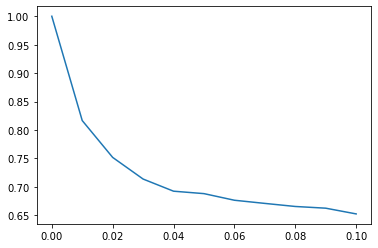

In [309]:
#checking relation between var and infidelity

fid = np.zeros([11, 1000])
k=0
for ij in range(11):
    var = 0.01*ij
    for jk in range(1000):
        rho = mixed_state(d=8)
        rho_noisy = noise_state(rho, var)

        fid[ij, jk] = qt.fidelity(qt.Qobj(rho), qt.Qobj(rho_noisy))
        
plt.plot(0.01*np.arange(11), np.mean(fid, axis=1))

In [533]:
data_pts = 10000
d = 8
var_vals = 5
k = np.zeros(64)

I = np.array([[1, 0],
              [0, 1]], dtype = 'complex')
X = np.array([[0, 1],
              [1, 0]], dtype = 'complex')
Y = np.array([[0, -1j],
              [1j, 0]], dtype = 'complex')
Z = np.array([[1, 0],
              [0, -1]], dtype = 'complex')

pauli = np.array([I, X, Y ,Z], dtype = 'complex')

var_0_L = np.zeros([data_pts, 64])
var_0_I = np.zeros([data_pts, 64])
v0 = 0

var_1_L = np.zeros([data_pts, 64])
var_1_I = np.zeros([data_pts, 64])
v1 = 0

var_2_L = np.zeros([data_pts, 64])
var_2_I = np.zeros([data_pts, 64])
v2 = 0

var_3_L = np.zeros([data_pts, 64])
var_3_I = np.zeros([data_pts, 64])
v3 = 0

var_4_L = np.zeros([data_pts, 64])
var_4_I = np.zeros([data_pts, 64])
v4 = 0

for ij in range(data_pts):
    
    rho = mixed_state(d)
    
    for jk in range(var_vals):
        var = 0.01*jk
        rho_noisy = noise_state(rho, var)
        
        temp_labels = np.zeros([4,4,4])
        temp_inputs = np.zeros([4,4,4])
        
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    optrs = np.kron(pauli[i], np.kron(pauli[j], pauli[k]))
                    temp_labels[i, j, k] = np.trace(np.matmul(optrs, rho))
                    temp_inputs[i, j, k] = np.trace(np.matmul(optrs, rho_noisy))
         
        if jk == 0:
            var_0_L[v0] = temp_labels.reshape(64)
            var_0_I[v0] = temp_inputs.reshape(64)
            v0 += 1
        
        if jk == 1:
            var_1_L[v1] = temp_labels.reshape(64)
            var_1_I[v1] = temp_inputs.reshape(64)
            v1 += 1
            
        if jk == 2:
            var_2_L[v2] = temp_labels.reshape(64)
            var_2_I[v2] = temp_inputs.reshape(64)
            v2 += 1
        
        if jk == 3:
            var_3_L[v3] = temp_labels.reshape(64)
            var_3_I[v3] = temp_inputs.reshape(64)
            v3 += 1
            
        if jk == 4:
            var_4_L[v4] = temp_labels.reshape(64)
            var_4_I[v4] = temp_inputs.reshape(64)
            v4 += 1     

<ipython-input-533-e73a570f515f>:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_labels[i, j, k] = np.trace(np.matmul(optrs, rho))
<ipython-input-533-e73a570f515f>:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_inputs[i, j, k] = np.trace(np.matmul(optrs, rho_noisy))


In [570]:
def state_recon_bloch_vec(pauli, r):
    
    """return state given pauli X, Y, Z and bloch vectors of size d**qbts
    """
    var_0_L_a = r.reshape(4,4,4)
    state_act = np.zeros([8,8], dtype = 'complex')

    for i in range(4):
        for j in range(4):
            for k in range(4):
                optrs = np.kron(pauli[i], np.kron(pauli[j], pauli[k]))
                state_act += var_0_L_a[i, j, k]*optrs
    
    return state_act/8
                
state_act = state_recon_bloch_vec(pauli, var_4_L[2])
state_est = state_recon_bloch_vec(pauli, var_4_I[2])
            
qt.fidelity(qt.Qobj(state_act), qt.Qobj(state_est))

def fid_avg(pauli, r_noise, r_actual, l):
    
    fidelity = 0.0
    for ij in range(l):
        a = state_recon_bloch_vec(pauli, r_noise[ij])
        b = state_recon_bloch_vec(pauli, r_actual[ij])
        fidelity += qt.fidelity(qt.Qobj(a), qt.Qobj(b))
    return fidelity/l

a = fid_avg(pauli, var_0_I, var_0_L, data_pts)
b = fid_avg(pauli, var_1_I, var_1_L, data_pts)
c = fid_avg(pauli, var_2_I, var_2_L, data_pts)
d = fid_avg(pauli, var_3_I, var_3_L, data_pts)
e = fid_avg(pauli, var_4_I, var_4_L, data_pts)

print(a, b, c, d, e)

0.9999999999999971 0.8133257710769483 0.7470423130329151 0.7132102512398958 0.698046986930631


In [535]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [794]:
#create datasets
#200 DMs for pure and mixed each
#perform 200 noisy meaurements on each with var=pi/6

M_dataset = var_0_I #1000x64
M_label = var_0_L #1000x64

In [795]:
M_ds = M_dataset.reshape(data_pts,1, 8, 8).real
M_l = M_label.reshape(data_pts, 64).real

In [796]:
ds_len = data_pts
test_size = 0.1
indices = list(range(ds_len))
np.random.shuffle(indices)
split = int(np.floor(test_size * ds_len))
train_idx, test_idx = indices[split:], indices[:split]

M_testset = M_ds[test_idx]
M_testlabel = M_l[test_idx]
M_trainset = M_ds[train_idx]
M_trainlabel = M_l[train_idx]

train_len = int(ds_len*(1-test_size))
valid_size = 0.2
indices = list(range(train_len))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_len))
train_idx, valid_idx = indices[split:], indices[:split]

M_validset = M_trainset[valid_idx]
M_validlabel = M_trainlabel[valid_idx]
M_trainset = M_trainset[train_idx]
M_trainlabel = M_trainlabel[train_idx]

In [797]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 50

#mixed_train_set
M_trainset = torch.Tensor(M_trainset) # transform to torch tensor
M_trainlabel = torch.tensor(M_trainlabel)

#mixed_valid set
M_validset = torch.Tensor(M_validset) # transform to torch tensor
M_validlabel = torch.tensor(M_validlabel)

#mixed_test set
M_testset = torch.Tensor(M_testset) # transform to torch tensor
M_testlabel = torch.tensor(M_testlabel)

#datasets
train_data = TensorDataset(M_trainset, M_trainlabel)
valid_data = TensorDataset(M_validset, M_validlabel)
test_data = TensorDataset(M_testset, M_testlabel)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [767]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 8x8x1 image tensor)
        self.conv1 = nn.Conv2d(1, 24, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(24)
        self.dropout1 = nn.Dropout2d(0.25)
#         convolutional layer (sees 4x4x12 tensor)
        self.conv2 = nn.Conv2d(24, 128, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
#         # convolutional layer (sees 2x2x64 tensor)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3_bn = nn.BatchNorm2d(128)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (128 * 2 * 2 -> 450)
        self.fc1 = nn.Linear(2048, 256)
        # linear layer (256 -> 64)
        self.fc2 = nn.Linear(256, 64)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.10)
        self.m = nn.ELU()
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_bn(x)
#         x = self.pool(x)
#         x = F.relu(self.conv3(x))
#         x = self.conv3_bn(x)

        # flatten input
        x = x.view(-1, 2048)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.m(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.m(self.fc2(x))
        return x

In [768]:
import torch.optim as optim

model = Net()

# specify loss function (categorical cross-entropy)
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)
# optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [769]:
# create a complete CNN
# trained pn v1

print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

# number of epochs to train the model
n_epochs = 2000
# model = model.float()
valid_loss_min = np.Inf # track change in validation loss

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            data, target = data.float(), target.float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # At completion of epoch
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '2020_ML_Assisted_QSE.pt')
        valid_loss_min = valid_loss

Net(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(24, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (m): ELU(alpha=1.0)
)
Epoch: 1 	Training Loss: 0.044005 	Validation Loss: 0.019841
Validation loss decreased (inf --> 0.019841).  Saving model ...
Epoch: 2 	Training Loss: 0.030422 	Validation Loss: 0.017511
Validation loss decreased (0.019841 --> 0.017511).  Saving model ...
Epoch: 3 	Training Loss: 0.027382 	Validation Loss: 0.016755
Validation lo

Epoch: 83 	Training Loss: 0.015399 	Validation Loss: 0.014837
Epoch: 84 	Training Loss: 0.015404 	Validation Loss: 0.014819
Epoch: 85 	Training Loss: 0.015370 	Validation Loss: 0.014833
Epoch: 86 	Training Loss: 0.015367 	Validation Loss: 0.014804
Epoch: 87 	Training Loss: 0.015393 	Validation Loss: 0.014790
Validation loss decreased (0.014797 --> 0.014790).  Saving model ...
Epoch: 88 	Training Loss: 0.015356 	Validation Loss: 0.014804
Epoch: 89 	Training Loss: 0.015361 	Validation Loss: 0.014826
Epoch: 90 	Training Loss: 0.015314 	Validation Loss: 0.014803
Epoch: 91 	Training Loss: 0.015318 	Validation Loss: 0.014801
Epoch: 92 	Training Loss: 0.015302 	Validation Loss: 0.014835
Epoch: 93 	Training Loss: 0.015311 	Validation Loss: 0.014767
Validation loss decreased (0.014790 --> 0.014767).  Saving model ...
Epoch: 94 	Training Loss: 0.015301 	Validation Loss: 0.014813
Epoch: 95 	Training Loss: 0.015289 	Validation Loss: 0.014759
Validation loss decreased (0.014767 --> 0.014759).  Savi

Epoch: 184 	Training Loss: 0.014770 	Validation Loss: 0.014594
Epoch: 185 	Training Loss: 0.014758 	Validation Loss: 0.014589
Validation loss decreased (0.014592 --> 0.014589).  Saving model ...
Epoch: 186 	Training Loss: 0.014763 	Validation Loss: 0.014568
Validation loss decreased (0.014589 --> 0.014568).  Saving model ...
Epoch: 187 	Training Loss: 0.014759 	Validation Loss: 0.014586
Epoch: 188 	Training Loss: 0.014755 	Validation Loss: 0.014606
Epoch: 189 	Training Loss: 0.014750 	Validation Loss: 0.014586
Epoch: 190 	Training Loss: 0.014742 	Validation Loss: 0.014587
Epoch: 191 	Training Loss: 0.014739 	Validation Loss: 0.014586
Epoch: 192 	Training Loss: 0.014746 	Validation Loss: 0.014566
Validation loss decreased (0.014568 --> 0.014566).  Saving model ...
Epoch: 193 	Training Loss: 0.014746 	Validation Loss: 0.014586
Epoch: 194 	Training Loss: 0.014729 	Validation Loss: 0.014594
Epoch: 195 	Training Loss: 0.014733 	Validation Loss: 0.014590
Epoch: 196 	Training Loss: 0.014707 	

Epoch: 288 	Training Loss: 0.014468 	Validation Loss: 0.014501
Epoch: 289 	Training Loss: 0.014487 	Validation Loss: 0.014502
Epoch: 290 	Training Loss: 0.014486 	Validation Loss: 0.014491
Validation loss decreased (0.014494 --> 0.014491).  Saving model ...
Epoch: 291 	Training Loss: 0.014457 	Validation Loss: 0.014513
Epoch: 292 	Training Loss: 0.014473 	Validation Loss: 0.014504
Epoch: 293 	Training Loss: 0.014479 	Validation Loss: 0.014501
Epoch: 294 	Training Loss: 0.014463 	Validation Loss: 0.014508
Epoch: 295 	Training Loss: 0.014471 	Validation Loss: 0.014502
Epoch: 296 	Training Loss: 0.014458 	Validation Loss: 0.014502
Epoch: 297 	Training Loss: 0.014477 	Validation Loss: 0.014495
Epoch: 298 	Training Loss: 0.014462 	Validation Loss: 0.014501
Epoch: 299 	Training Loss: 0.014472 	Validation Loss: 0.014509
Epoch: 300 	Training Loss: 0.014461 	Validation Loss: 0.014515
Epoch: 301 	Training Loss: 0.014444 	Validation Loss: 0.014506
Epoch: 302 	Training Loss: 0.014458 	Validation L

Epoch: 404 	Training Loss: 0.014288 	Validation Loss: 0.014461
Epoch: 405 	Training Loss: 0.014279 	Validation Loss: 0.014464
Epoch: 406 	Training Loss: 0.014286 	Validation Loss: 0.014463
Epoch: 407 	Training Loss: 0.014289 	Validation Loss: 0.014457
Validation loss decreased (0.014457 --> 0.014457).  Saving model ...
Epoch: 408 	Training Loss: 0.014295 	Validation Loss: 0.014463
Epoch: 409 	Training Loss: 0.014272 	Validation Loss: 0.014467
Epoch: 410 	Training Loss: 0.014268 	Validation Loss: 0.014460
Epoch: 411 	Training Loss: 0.014288 	Validation Loss: 0.014459
Epoch: 412 	Training Loss: 0.014277 	Validation Loss: 0.014462
Epoch: 413 	Training Loss: 0.014289 	Validation Loss: 0.014463
Epoch: 414 	Training Loss: 0.014286 	Validation Loss: 0.014459
Epoch: 415 	Training Loss: 0.014291 	Validation Loss: 0.014466
Epoch: 416 	Training Loss: 0.014271 	Validation Loss: 0.014460
Epoch: 417 	Training Loss: 0.014272 	Validation Loss: 0.014459
Epoch: 418 	Training Loss: 0.014268 	Validation L

Epoch: 520 	Training Loss: 0.014138 	Validation Loss: 0.014439
Epoch: 521 	Training Loss: 0.014145 	Validation Loss: 0.014442
Epoch: 522 	Training Loss: 0.014133 	Validation Loss: 0.014440
Epoch: 523 	Training Loss: 0.014147 	Validation Loss: 0.014438
Epoch: 524 	Training Loss: 0.014126 	Validation Loss: 0.014439
Epoch: 525 	Training Loss: 0.014142 	Validation Loss: 0.014438
Epoch: 526 	Training Loss: 0.014136 	Validation Loss: 0.014440
Epoch: 527 	Training Loss: 0.014124 	Validation Loss: 0.014439
Epoch: 528 	Training Loss: 0.014126 	Validation Loss: 0.014440
Epoch: 529 	Training Loss: 0.014128 	Validation Loss: 0.014440
Epoch: 530 	Training Loss: 0.014119 	Validation Loss: 0.014438
Epoch: 531 	Training Loss: 0.014121 	Validation Loss: 0.014435
Validation loss decreased (0.014436 --> 0.014435).  Saving model ...
Epoch: 532 	Training Loss: 0.014113 	Validation Loss: 0.014442
Epoch: 533 	Training Loss: 0.014127 	Validation Loss: 0.014444
Epoch: 534 	Training Loss: 0.014107 	Validation L

Epoch: 634 	Training Loss: 0.014002 	Validation Loss: 0.014423
Validation loss decreased (0.014424 --> 0.014423).  Saving model ...
Epoch: 635 	Training Loss: 0.014013 	Validation Loss: 0.014429
Epoch: 636 	Training Loss: 0.013990 	Validation Loss: 0.014422
Validation loss decreased (0.014423 --> 0.014422).  Saving model ...
Epoch: 637 	Training Loss: 0.013988 	Validation Loss: 0.014428
Epoch: 638 	Training Loss: 0.014013 	Validation Loss: 0.014424
Epoch: 639 	Training Loss: 0.013989 	Validation Loss: 0.014427
Epoch: 640 	Training Loss: 0.013993 	Validation Loss: 0.014429
Epoch: 641 	Training Loss: 0.013984 	Validation Loss: 0.014429
Epoch: 642 	Training Loss: 0.014005 	Validation Loss: 0.014428
Epoch: 643 	Training Loss: 0.014007 	Validation Loss: 0.014428
Epoch: 644 	Training Loss: 0.013999 	Validation Loss: 0.014429
Epoch: 645 	Training Loss: 0.013964 	Validation Loss: 0.014423
Epoch: 646 	Training Loss: 0.013994 	Validation Loss: 0.014428
Epoch: 647 	Training Loss: 0.013993 	Valida

Epoch: 752 	Training Loss: 0.013876 	Validation Loss: 0.014420
Epoch: 753 	Training Loss: 0.013856 	Validation Loss: 0.014427
Epoch: 754 	Training Loss: 0.013874 	Validation Loss: 0.014416
Epoch: 755 	Training Loss: 0.013858 	Validation Loss: 0.014428
Epoch: 756 	Training Loss: 0.013861 	Validation Loss: 0.014417
Epoch: 757 	Training Loss: 0.013854 	Validation Loss: 0.014422
Epoch: 758 	Training Loss: 0.013865 	Validation Loss: 0.014423
Epoch: 759 	Training Loss: 0.013855 	Validation Loss: 0.014420
Epoch: 760 	Training Loss: 0.013877 	Validation Loss: 0.014421
Epoch: 761 	Training Loss: 0.013880 	Validation Loss: 0.014418
Epoch: 762 	Training Loss: 0.013865 	Validation Loss: 0.014421
Epoch: 763 	Training Loss: 0.013860 	Validation Loss: 0.014419
Epoch: 764 	Training Loss: 0.013860 	Validation Loss: 0.014425
Epoch: 765 	Training Loss: 0.013848 	Validation Loss: 0.014422
Epoch: 766 	Training Loss: 0.013855 	Validation Loss: 0.014417
Epoch: 767 	Training Loss: 0.013876 	Validation Loss: 0

Epoch: 881 	Training Loss: 0.013747 	Validation Loss: 0.014416
Epoch: 882 	Training Loss: 0.013730 	Validation Loss: 0.014418
Epoch: 883 	Training Loss: 0.013740 	Validation Loss: 0.014415
Epoch: 884 	Training Loss: 0.013709 	Validation Loss: 0.014416
Epoch: 885 	Training Loss: 0.013730 	Validation Loss: 0.014417
Epoch: 886 	Training Loss: 0.013737 	Validation Loss: 0.014419
Epoch: 887 	Training Loss: 0.013714 	Validation Loss: 0.014418
Epoch: 888 	Training Loss: 0.013724 	Validation Loss: 0.014417
Epoch: 889 	Training Loss: 0.013726 	Validation Loss: 0.014418
Epoch: 890 	Training Loss: 0.013726 	Validation Loss: 0.014417
Epoch: 891 	Training Loss: 0.013726 	Validation Loss: 0.014415
Epoch: 892 	Training Loss: 0.013726 	Validation Loss: 0.014414
Epoch: 893 	Training Loss: 0.013728 	Validation Loss: 0.014414
Epoch: 894 	Training Loss: 0.013736 	Validation Loss: 0.014414
Epoch: 895 	Training Loss: 0.013694 	Validation Loss: 0.014413
Epoch: 896 	Training Loss: 0.013721 	Validation Loss: 0

Epoch: 1008 	Training Loss: 0.013596 	Validation Loss: 0.014419
Epoch: 1009 	Training Loss: 0.013595 	Validation Loss: 0.014415
Epoch: 1010 	Training Loss: 0.013600 	Validation Loss: 0.014417
Epoch: 1011 	Training Loss: 0.013586 	Validation Loss: 0.014422
Epoch: 1012 	Training Loss: 0.013574 	Validation Loss: 0.014419
Epoch: 1013 	Training Loss: 0.013572 	Validation Loss: 0.014413
Epoch: 1014 	Training Loss: 0.013581 	Validation Loss: 0.014419
Epoch: 1015 	Training Loss: 0.013597 	Validation Loss: 0.014418
Epoch: 1016 	Training Loss: 0.013580 	Validation Loss: 0.014420
Epoch: 1017 	Training Loss: 0.013578 	Validation Loss: 0.014422
Epoch: 1018 	Training Loss: 0.013589 	Validation Loss: 0.014422
Epoch: 1019 	Training Loss: 0.013573 	Validation Loss: 0.014423
Epoch: 1020 	Training Loss: 0.013591 	Validation Loss: 0.014414
Epoch: 1021 	Training Loss: 0.013579 	Validation Loss: 0.014415
Epoch: 1022 	Training Loss: 0.013593 	Validation Loss: 0.014414
Epoch: 1023 	Training Loss: 0.013571 	Va

Epoch: 1137 	Training Loss: 0.013466 	Validation Loss: 0.014419
Epoch: 1138 	Training Loss: 0.013464 	Validation Loss: 0.014427
Epoch: 1139 	Training Loss: 0.013466 	Validation Loss: 0.014425
Epoch: 1140 	Training Loss: 0.013460 	Validation Loss: 0.014427
Epoch: 1141 	Training Loss: 0.013457 	Validation Loss: 0.014421
Epoch: 1142 	Training Loss: 0.013459 	Validation Loss: 0.014422
Epoch: 1143 	Training Loss: 0.013476 	Validation Loss: 0.014425
Epoch: 1144 	Training Loss: 0.013439 	Validation Loss: 0.014423
Epoch: 1145 	Training Loss: 0.013458 	Validation Loss: 0.014428
Epoch: 1146 	Training Loss: 0.013440 	Validation Loss: 0.014418
Epoch: 1147 	Training Loss: 0.013464 	Validation Loss: 0.014420
Epoch: 1148 	Training Loss: 0.013462 	Validation Loss: 0.014416
Epoch: 1149 	Training Loss: 0.013451 	Validation Loss: 0.014428
Epoch: 1150 	Training Loss: 0.013470 	Validation Loss: 0.014423
Epoch: 1151 	Training Loss: 0.013428 	Validation Loss: 0.014421
Epoch: 1152 	Training Loss: 0.013448 	Va

Epoch: 1266 	Training Loss: 0.013343 	Validation Loss: 0.014431
Epoch: 1267 	Training Loss: 0.013355 	Validation Loss: 0.014433
Epoch: 1268 	Training Loss: 0.013338 	Validation Loss: 0.014425
Epoch: 1269 	Training Loss: 0.013336 	Validation Loss: 0.014426
Epoch: 1270 	Training Loss: 0.013328 	Validation Loss: 0.014431
Epoch: 1271 	Training Loss: 0.013341 	Validation Loss: 0.014429
Epoch: 1272 	Training Loss: 0.013336 	Validation Loss: 0.014426
Epoch: 1273 	Training Loss: 0.013324 	Validation Loss: 0.014432
Epoch: 1274 	Training Loss: 0.013326 	Validation Loss: 0.014425
Epoch: 1275 	Training Loss: 0.013329 	Validation Loss: 0.014428
Epoch: 1276 	Training Loss: 0.013326 	Validation Loss: 0.014432
Epoch: 1277 	Training Loss: 0.013343 	Validation Loss: 0.014428
Epoch: 1278 	Training Loss: 0.013331 	Validation Loss: 0.014441
Epoch: 1279 	Training Loss: 0.013334 	Validation Loss: 0.014430
Epoch: 1280 	Training Loss: 0.013339 	Validation Loss: 0.014423
Epoch: 1281 	Training Loss: 0.013288 	Va

Epoch: 1395 	Training Loss: 0.013230 	Validation Loss: 0.014447
Epoch: 1396 	Training Loss: 0.013230 	Validation Loss: 0.014437
Epoch: 1397 	Training Loss: 0.013198 	Validation Loss: 0.014439
Epoch: 1398 	Training Loss: 0.013197 	Validation Loss: 0.014437
Epoch: 1399 	Training Loss: 0.013216 	Validation Loss: 0.014442
Epoch: 1400 	Training Loss: 0.013179 	Validation Loss: 0.014444
Epoch: 1401 	Training Loss: 0.013217 	Validation Loss: 0.014445
Epoch: 1402 	Training Loss: 0.013221 	Validation Loss: 0.014441
Epoch: 1403 	Training Loss: 0.013239 	Validation Loss: 0.014443
Epoch: 1404 	Training Loss: 0.013214 	Validation Loss: 0.014441
Epoch: 1405 	Training Loss: 0.013212 	Validation Loss: 0.014438
Epoch: 1406 	Training Loss: 0.013209 	Validation Loss: 0.014440
Epoch: 1407 	Training Loss: 0.013197 	Validation Loss: 0.014440
Epoch: 1408 	Training Loss: 0.013208 	Validation Loss: 0.014445
Epoch: 1409 	Training Loss: 0.013194 	Validation Loss: 0.014444
Epoch: 1410 	Training Loss: 0.013209 	Va

Epoch: 1524 	Training Loss: 0.013103 	Validation Loss: 0.014452
Epoch: 1525 	Training Loss: 0.013107 	Validation Loss: 0.014457
Epoch: 1526 	Training Loss: 0.013096 	Validation Loss: 0.014448
Epoch: 1527 	Training Loss: 0.013113 	Validation Loss: 0.014450
Epoch: 1528 	Training Loss: 0.013095 	Validation Loss: 0.014454
Epoch: 1529 	Training Loss: 0.013114 	Validation Loss: 0.014449
Epoch: 1530 	Training Loss: 0.013109 	Validation Loss: 0.014445
Epoch: 1531 	Training Loss: 0.013116 	Validation Loss: 0.014450
Epoch: 1532 	Training Loss: 0.013092 	Validation Loss: 0.014460
Epoch: 1533 	Training Loss: 0.013067 	Validation Loss: 0.014450
Epoch: 1534 	Training Loss: 0.013081 	Validation Loss: 0.014455
Epoch: 1535 	Training Loss: 0.013101 	Validation Loss: 0.014461
Epoch: 1536 	Training Loss: 0.013109 	Validation Loss: 0.014451
Epoch: 1537 	Training Loss: 0.013109 	Validation Loss: 0.014461
Epoch: 1538 	Training Loss: 0.013089 	Validation Loss: 0.014458
Epoch: 1539 	Training Loss: 0.013063 	Va

Epoch: 1653 	Training Loss: 0.013004 	Validation Loss: 0.014485
Epoch: 1654 	Training Loss: 0.013017 	Validation Loss: 0.014474
Epoch: 1655 	Training Loss: 0.013001 	Validation Loss: 0.014473
Epoch: 1656 	Training Loss: 0.012974 	Validation Loss: 0.014476
Epoch: 1657 	Training Loss: 0.012971 	Validation Loss: 0.014478
Epoch: 1658 	Training Loss: 0.013004 	Validation Loss: 0.014480
Epoch: 1659 	Training Loss: 0.012993 	Validation Loss: 0.014466
Epoch: 1660 	Training Loss: 0.012979 	Validation Loss: 0.014475
Epoch: 1661 	Training Loss: 0.012980 	Validation Loss: 0.014479
Epoch: 1662 	Training Loss: 0.012984 	Validation Loss: 0.014482
Epoch: 1663 	Training Loss: 0.013011 	Validation Loss: 0.014468
Epoch: 1664 	Training Loss: 0.012986 	Validation Loss: 0.014473
Epoch: 1665 	Training Loss: 0.012980 	Validation Loss: 0.014475
Epoch: 1666 	Training Loss: 0.012947 	Validation Loss: 0.014474
Epoch: 1667 	Training Loss: 0.012990 	Validation Loss: 0.014479
Epoch: 1668 	Training Loss: 0.013001 	Va

Epoch: 1782 	Training Loss: 0.012874 	Validation Loss: 0.014498
Epoch: 1783 	Training Loss: 0.012882 	Validation Loss: 0.014498
Epoch: 1784 	Training Loss: 0.012898 	Validation Loss: 0.014495
Epoch: 1785 	Training Loss: 0.012906 	Validation Loss: 0.014499
Epoch: 1786 	Training Loss: 0.012879 	Validation Loss: 0.014494
Epoch: 1787 	Training Loss: 0.012903 	Validation Loss: 0.014494
Epoch: 1788 	Training Loss: 0.012894 	Validation Loss: 0.014493
Epoch: 1789 	Training Loss: 0.012881 	Validation Loss: 0.014505
Epoch: 1790 	Training Loss: 0.012878 	Validation Loss: 0.014489
Epoch: 1791 	Training Loss: 0.012901 	Validation Loss: 0.014495
Epoch: 1792 	Training Loss: 0.012873 	Validation Loss: 0.014496
Epoch: 1793 	Training Loss: 0.012898 	Validation Loss: 0.014498
Epoch: 1794 	Training Loss: 0.012892 	Validation Loss: 0.014505
Epoch: 1795 	Training Loss: 0.012902 	Validation Loss: 0.014499
Epoch: 1796 	Training Loss: 0.012864 	Validation Loss: 0.014493
Epoch: 1797 	Training Loss: 0.012886 	Va

Epoch: 1911 	Training Loss: 0.012800 	Validation Loss: 0.014509
Epoch: 1912 	Training Loss: 0.012809 	Validation Loss: 0.014508
Epoch: 1913 	Training Loss: 0.012784 	Validation Loss: 0.014513
Epoch: 1914 	Training Loss: 0.012778 	Validation Loss: 0.014515
Epoch: 1915 	Training Loss: 0.012801 	Validation Loss: 0.014516
Epoch: 1916 	Training Loss: 0.012792 	Validation Loss: 0.014528
Epoch: 1917 	Training Loss: 0.012785 	Validation Loss: 0.014518
Epoch: 1918 	Training Loss: 0.012787 	Validation Loss: 0.014525
Epoch: 1919 	Training Loss: 0.012803 	Validation Loss: 0.014521
Epoch: 1920 	Training Loss: 0.012793 	Validation Loss: 0.014525
Epoch: 1921 	Training Loss: 0.012776 	Validation Loss: 0.014520
Epoch: 1922 	Training Loss: 0.012799 	Validation Loss: 0.014522
Epoch: 1923 	Training Loss: 0.012792 	Validation Loss: 0.014511
Epoch: 1924 	Training Loss: 0.012777 	Validation Loss: 0.014519
Epoch: 1925 	Training Loss: 0.012766 	Validation Loss: 0.014521
Epoch: 1926 	Training Loss: 0.012786 	Va

Text(0.5, 1.0, 'V1')

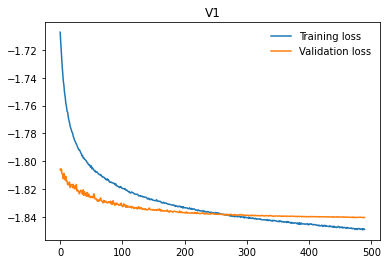

In [773]:
plt.plot(np.log10(train_losses[10:500]), label='Training loss')
plt.plot(np.log10(valid_losses[10:500]), label='Validation loss')
plt.legend(frameon=False)
plt.title('V1')

In [792]:
model.load_state_dict(torch.load('2020_ML_Assisted_QSE.pt'))

<All keys matched successfully>

In [775]:
# track test loss on v1
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(pauli, aa)
                rho2 = state_recon_bloch_vec(pauli, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.014362
Loss per Batch: 0.014204
Loss per Batch: 0.013942
Loss per Batch: 0.014032
Loss per Batch: 0.015123
Loss per Batch: 0.014069
Loss per Batch: 0.013598
Loss per Batch: 0.014212
Loss per Batch: 0.013726
Loss per Batch: 0.013772
Loss per Batch: 0.013883
Loss per Batch: 0.014951
Loss per Batch: 0.013841
Loss per Batch: 0.014987
Loss per Batch: 0.014456
Loss per Batch: 0.014184
Loss per Batch: 0.013720
Loss per Batch: 0.013625
Loss per Batch: 0.014392
Loss per Batch: 0.013919
Final Test Loss: 0.014150
Average Fidelity: 0.861356


In [781]:
# track test loss on v2
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(pauli, aa)
                rho2 = state_recon_bloch_vec(pauli, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.015311
Loss per Batch: 0.015397
Loss per Batch: 0.016250
Loss per Batch: 0.015715
Loss per Batch: 0.015962
Loss per Batch: 0.015560
Loss per Batch: 0.015338
Loss per Batch: 0.015500
Loss per Batch: 0.014302
Loss per Batch: 0.015082
Loss per Batch: 0.015496
Loss per Batch: 0.016135
Loss per Batch: 0.016242
Loss per Batch: 0.014893
Loss per Batch: 0.015495
Loss per Batch: 0.015119
Loss per Batch: 0.015461
Loss per Batch: 0.015142
Loss per Batch: 0.014862
Loss per Batch: 0.016090
Final Test Loss: 0.015468
Average Fidelity: 0.851827


In [787]:
# track test loss on v3
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(pauli, aa)
                rho2 = state_recon_bloch_vec(pauli, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.016293
Loss per Batch: 0.015184
Loss per Batch: 0.015640
Loss per Batch: 0.016611
Loss per Batch: 0.016212
Loss per Batch: 0.016101
Loss per Batch: 0.015034
Loss per Batch: 0.016354
Loss per Batch: 0.016093
Loss per Batch: 0.016125
Loss per Batch: 0.016205
Loss per Batch: 0.015933
Loss per Batch: 0.016253
Loss per Batch: 0.015574
Loss per Batch: 0.016389
Loss per Batch: 0.016141
Loss per Batch: 0.015487
Loss per Batch: 0.015896
Loss per Batch: 0.015825
Loss per Batch: 0.016370
Final Test Loss: 0.015986
Average Fidelity: 0.847331


In [793]:
# track test loss on v4
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(pauli, aa)
                rho2 = state_recon_bloch_vec(pauli, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.016765
Loss per Batch: 0.016935
Loss per Batch: 0.016017
Loss per Batch: 0.016673
Loss per Batch: 0.016532
Loss per Batch: 0.016408
Loss per Batch: 0.016440
Loss per Batch: 0.015260
Loss per Batch: 0.015649
Loss per Batch: 0.016745
Loss per Batch: 0.016219
Loss per Batch: 0.015702
Loss per Batch: 0.016194
Loss per Batch: 0.016466
Loss per Batch: 0.016826
Loss per Batch: 0.015507
Loss per Batch: 0.015897
Loss per Batch: 0.016804
Loss per Batch: 0.016682
Loss per Batch: 0.016165
Final Test Loss: 0.016294
Average Fidelity: 0.845162


In [798]:
# track test loss on v0
test_loss = 0.0
fidelity = 0.0
if train_on_gpu:
    model.cuda()
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        with torch.no_grad():
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            for ij in range(batch_size):
                aa = np.array(output.cpu().numpy()[ij])
                bb = np.array(target.cpu().numpy()[ij])
                rho1 = state_recon_bloch_vec(pauli, aa)
                rho2 = state_recon_bloch_vec(pauli, bb)
                rho1 = eig_val_corr(rho1)
                rho2 = eig_val_corr(rho2)
                fidelity += qt.fidelity(qt.Qobj(rho1), qt.Qobj(rho2))
                
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            test_loss += loss.item()*data.size(0)
    print('Loss per Batch: {:.6f}'.format(loss))
    
# calculate average losses
test_loss = test_loss/len(test_loader.sampler)
fidelity = fidelity/len(test_loader.sampler)

# print training/validation statistics 
print('Final Test Loss: {:.6f}'.format(test_loss))
print('Average Fidelity: {:.6f}'.format(fidelity))

Loss per Batch: 0.011168
Loss per Batch: 0.011683
Loss per Batch: 0.011419
Loss per Batch: 0.011394
Loss per Batch: 0.010965
Loss per Batch: 0.010842
Loss per Batch: 0.011105
Loss per Batch: 0.011069
Loss per Batch: 0.011301
Loss per Batch: 0.010599
Loss per Batch: 0.011074
Loss per Batch: 0.011716
Loss per Batch: 0.010902
Loss per Batch: 0.010554
Loss per Batch: 0.010256
Loss per Batch: 0.010956
Loss per Batch: 0.011623
Loss per Batch: 0.010758
Loss per Batch: 0.010478
Loss per Batch: 0.011403
Final Test Loss: 0.011063
Average Fidelity: 0.885972


Trained on v1 for 2000 epochs

#v0    
Final Test Loss: 0.011063    
Average Fidelity: 0.885972

#v1   
Final Test Loss: 0.014150   
Average Fidelity: 0.861356
    
#v2   
Final Test Loss: 0.015468   
Average Fidelity: 0.851827
    
#v3   
Final Test Loss: 0.015986   
Average Fidelity: 0.847331
    
#v4   
Final Test Loss: 0.016294  
Average Fidelity: 0.845162